# Deepfake Detection - Model Evaluation

> To ignore the repeated code **start here:** [Evaluation functions](#evaluation-functions)

## Setup and Imports

In [1]:
from platform import python_version

python_version()

'3.9.12'

In [2]:
import tensorflow as tf
from tensorflow import keras

tf.__version__, keras.__version__

('2.9.1', '2.9.0')

In [144]:
import os

# Check GPUs available
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Enables use of the GPU on a Mac using plaidml (ignore otherwise)

Num GPUs Available:  1


In [4]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import pandas as pd
import pickle
import random
import sys

from tqdm import tqdm

from typing import List

## Load dataset

In [5]:
DATASET_PATH = "../dataset-sample-faces.csv"

In [79]:
data = pd.read_csv(DATASET_PATH)

data.head()

,image_filename,image_fullpath,face_confidence,label,video_filename,video_fullpath,video_dataset
0,id0_0000_1.png,../extracted_faces/id0_0000/id0_0000_1.png,0.997610,REAL,id0_0000.mp4,../datasets/Celeb-DF-v2/Celeb-real/id0_0000.mp4,Celeb-DF-v2
1,id0_0000_15.png,../extracted_faces/id0_0000/id0_0000_15.png,0.996413,REAL,id0_0000.mp4,../datasets/Celeb-DF-v2/Celeb-real/id0_0000.mp4,Celeb-DF-v2
2,id0_0000_29.png,../extracted_faces/id0_0000/id0_0000_29.png,0.999750,REAL,id0_0000.mp4,../datasets/Celeb-DF-v2/Celeb-real/id0_0000.mp4,Celeb-DF-v2
3,id0_0000_43.png,../extracted_faces/id0_0000/id0_0000_43.png,0.995511,REAL,id0_0000.mp4,../datasets/Celeb-DF-v2/Celeb-real/id0_0000.mp4,Celeb-DF-v2
4,id0_0000_57.png,../extracted_faces/id0_0000/id0_0000_57.png,0.997212,REAL,id0_0000.mp4,../datasets/Celeb-DF-v2/Celeb-real/id0_0000.mp4,Celeb-DF-v2


In [88]:
random_path.replace("/","")

'C:\\Users\\Michelle\\Documents\\dev\\deepfake-detection\\model\\notebooks\\..extracted_facesid0_0000id0_0000_1.png'

In [7]:
list(data.columns)

['image_filename',
 'image_fullpath',
 'face_confidence',
 'label',
 'video_filename',
 'video_fullpath',
 'video_dataset']

In [8]:
data['label'].value_counts()

REAL    48200
FAKE    46832
Name: label, dtype: int64

In [9]:
data = data.sample(n=20000, random_state=42)

In [10]:
data['label'].value_counts()

REAL    10060
FAKE     9940
Name: label, dtype: int64

Although, there is a slight imbalance in the dataset as seen above, we sampled the number of "FAKE" videos equal to the number of "REAL" videos in the notebook [Deepfake Detection - Dataset Preparation.ipynb](./Deepfake%20Detection%20-%20Dataset%20Preparation.ipynb)

## Data Splitting

To ensure that images from a video in the train dataset is not in the validation/test dataset, a custom split function was made.

In [11]:
def split_dataframe(data, test_size, column, shuffle=False, random_state=1):
  """Splits the dataframe based on unique values in a given 
  column."""
  # Gets a list of unique videos 
  videos = list(data[column].unique())
  n = len(videos)
  k = int(0.2 * n)

  if shuffle:
    data = data.sample(frac=1)

  # Sets the random state
  random.seed(random_state)
  split_videos = random.sample(videos, k)

  df1 = data[data[column].isin(split_videos)]
  df2 = data[~data[column].isin(split_videos)]
  
  assert(len(df1[df1.isin(df2)].dropna()) == 0)
  
  df1.sort_index(inplace=True)
  df2.sort_index(inplace=True)
  
  return df2, df1

In [12]:
TRAIN_SPLIT = 0.2
VAL_SPLIT = 0.25

train_df, test_df = split_dataframe(data=data, 
                                    test_size=TRAIN_SPLIT,
                                    column="video_filename",
                                    shuffle=True,
                                    random_state=42)

train_df, val_df = split_dataframe(data=data, 
                                  test_size=VAL_SPLIT,
                                  column="video_filename",
                                  random_state=42)

C:\Users\Michelle\AppData\Local\Temp\ipykernel_27228\1251354954.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.sort_index(inplace=True)
C:\Users\Michelle\AppData\Local\Temp\ipykernel_27228\1251354954.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.sort_index(inplace=True)


In [13]:
train_df['label'].value_counts()

FAKE    8058
REAL    7942
Name: label, dtype: int64

In [14]:
test_df['label'].value_counts()

REAL    2118
FAKE    1882
Name: label, dtype: int64

In [15]:
val_df['label'].value_counts()

REAL    2118
FAKE    1882
Name: label, dtype: int64

## Data Augmentation 

**Gaussian Noise:**

**Random Erasing:** https://arxiv.org/abs/1708.04896
    - Source code: https://github.com/zhunzhong07/Random-Erasing

In [16]:
import math
import random
from keras.preprocessing.image import ImageDataGenerator

def gaussian_noise(image, probability):
  if random.uniform(0,1) > probability:
    return image
  row,col,ch= image.shape
  mean = 0
  var = 0.01 # slightly reduced
  sigma = var ** 0.5
  gauss = np.random.normal(mean,sigma,(row,col))
  noisy = image
  for i in range(ch):
    noisy[:,:,i] = image[:,:,i] + gauss
  return noisy


def random_erasing(img, probability):
  """
  Performs Random Erasing in Random Erasing Data Augmentation by Zhong et al.

  probability: The probability that the operation will be performed.
  sl: min erasing area
  sh: max erasing area
  r1: min aspect ratio
  mean: erasing value

  Note: Code modified for img.shape parameters instead of img.size()
  """
  # Source: https://github.com/zhunzhong07/Random-Erasing
  if random.uniform(0,1) > probability:
    return img

  # Default params
  mean = [0.4914, 0.4822, 0.4465]
  sl = 0.02
  sh = 0.4
  r1 = 0.3

  for attempt in range(100):
    area = img.shape[0] * img.shape[1]

    target_area = random.uniform(sl, sh) * area
    aspect_ratio = random.uniform(r1, 1/r1)

    h = int(round(math.sqrt(target_area * aspect_ratio)))
    w = int(round(math.sqrt(target_area / aspect_ratio)))

    if w < img.shape[0] and h < img.shape[1]:
        x1 = random.randint(0, img.shape[1] - h)
        y1 = random.randint(0, img.shape[0] - w)
        if img.shape[2] == 3:
            img[x1:x1+h, y1:y1+w, 0] = mean[0]
            img[x1:x1+h, y1:y1+w, 1] = mean[1]
            img[x1:x1+h, y1:y1+w, 2] = mean[2]
        else:
            img[0, x1:x1+h, y1:y1+w] = mean[0]

        return img
  return img

class CustomDataGenerator(ImageDataGenerator):
  '''
  Custom image data generator.
  Allows image compression and random erasing.
  '''
  def __init__(self, 
               gaussian_noise : float = 0., 
               random_erasing : float = 0.,
               **kwargs):
    super().__init__(preprocessing_function=self.custom_augmentations,
                    **kwargs)
    self.gaussian_noise = gaussian_noise
    self.random_erasing = random_erasing
  
  def custom_augmentations(self, image):
    image = gaussian_noise(image, self.gaussian_noise)
    image = random_erasing(image, self.random_erasing)
    return image

In [17]:
train_datagen = CustomDataGenerator(rescale=1./255,
                                  zoom_range=0.2,
                                  rotation_range=0.1,
                                  horizontal_flip=True,
                                  # Custom augmentation probabilities
                                  gaussian_noise=0.1,
                                  random_erasing=0.3)

test_datagen = ImageDataGenerator(rescale=1./255)

In [18]:
train_generator = train_datagen.flow_from_dataframe(
  dataframe = train_df,
  directory = ".",
  x_col = "image_fullpath",
  y_col = "label",
  batch_size = 64,
  seed = 42,
  class_mode = "binary",
  target_size=(128, 128)
)

valid_generator = train_datagen.flow_from_dataframe(
  dataframe = val_df,
  directory = ".",
  x_col = "image_fullpath",
  y_col = "label",
  batch_size = 64,
  seed = 42,
  class_mode = "binary",
  target_size=(128, 128)
)

test_generator = test_datagen.flow_from_dataframe(
  dataframe = test_df, 
  directory = ".",
  x_col = "image_fullpath",
  y_col = "label",
  batch_size=64,
  seed = 42,
  shuffle=False,
  class_mode="binary",
  target_size=(128, 128)
)

Found 16000 validated image filenames belonging to 2 classes.
Found 4000 validated image filenames belonging to 2 classes.
Found 4000 validated image filenames belonging to 2 classes.


# Model Evaluations

<a id='evaluation-functions'></a>

## Evaluation Functions

To ensure that we are predicting off the videos.

In [110]:
def model_predict(model, test_generator):
    # Runs prediction on test dataset
    test_generator.reset()
    pred = model.predict(test_generator,steps=len(test_generator), verbose=1)
    
    # Creates a dictionary to search for the video_filename: array of frame predictions
    real_labels = test_generator.labels
    filenames = test_generator.filenames
    prediction = {}
    real_prediction = {}
    for f, p, r in zip(filenames, pred, real_labels):
        pred_video_filename = test_df[test_df['image_fullpath'] == f]['video_filename'].iloc[0]
        if pred_video_filename in prediction.keys():
            prediction[pred_video_filename].append(p[0])
            real_prediction[pred_video_filename].append(r)
        else:
            prediction[pred_video_filename] = [ p[0] ]
            real_prediction[pred_video_filename] = [r]

    # Averages the prediction scores for each video
    prediction = { k: sum(v)/len(v) for k,v in prediction.items() }
    real_prediction = { k: int(sum(v)/len(v)) for k,v in real_prediction.items() }
    
    pred_vid_filenames = list(prediction.keys())
    pred_vid = list(prediction.values())
    real_indices = list(real_prediction.values())
    
    return pred_vid_filenames, pred_vid, real_indices

In [130]:
def predict_indices(pred, thresh=0.5):
    return [1 if p > thresh else 0 for p in pred ]

In [140]:
def show_classification_report(test_y, pred_y):
    report = classification_report(test_y, pred_y, digits=4, zero_division=0)
    print(report)

In [141]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def show_confusion_matrix(test_y, pred_y, axis_labels):
    confusion = confusion_matrix(test_y, pred_y)
    confusion_normalized = confusion.astype("float") / confusion.sum(axis=1)
    fig, ax = plt.subplots(figsize=(8,8))
    ax = sns.heatmap(confusion_normalized, 
                     xticklabels=axis_labels, 
                     yticklabels=axis_labels,
                     cmap='Blues', 
                     annot=True,
                     fmt = '.2f',
                     square = True
    )
    plt.title("Confusion Matrix")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()

## ResNet50

In [150]:
model = keras.models.load_model("../weights/resnet50-v0.h5")

In [154]:
# Evaluate based on pure image data
# Note: Not reflective of acutal deepfake accuracy
test_generator.reset()
image_loss, image_acc = model.evaluate(test_generator)
image_loss, image_acc

63/63 [==============================] - 27s 426ms/step - loss: 0.6765 - accuracy: 0.5810


(0.6765381097793579, 0.5809999704360962)

In [146]:
test_x, pred_y, test_y = model_predict(model, test_generator) 

63/63 [==============================] - 28s 371ms/step


In [147]:
# Converts predictions to binary
pred_y_indices = predict_indices(pred_y, thresh=0.5)

In [148]:
show_classification_report(test_y, pred_y_indices)

              precision    recall  f1-score   support

           0     0.5346    0.6159    0.5724       276
           1     0.6187    0.5375    0.5753       320

    accuracy                         0.5738       596
   macro avg     0.5766    0.5767    0.5738       596
weighted avg     0.5798    0.5738    0.5739       596



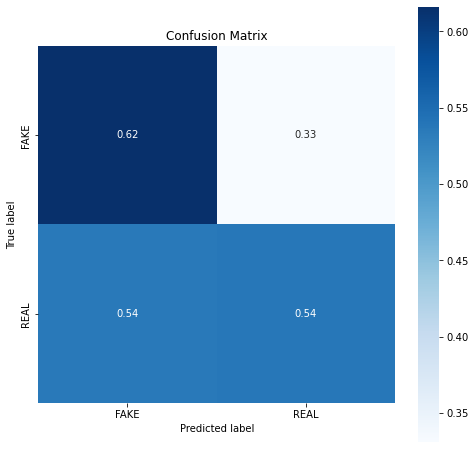

In [149]:
axis_labels = list(test_generator.class_indices)
show_confusion_matrix(test_y, pred_y_indices, axis_labels)

## EfficientNet-B7